# A1_2 – Manual Backpropagation Neural Network (Experiments)

In this notebook we:

- Load the preprocessed and encoded datasets (`./data`).
- Run all the experiments with different neural network hyperparameters
  (number of hidden layers, activation function, learning rate, momentum, epochs).
- Compare the experiments using:
  - MSE, MAE and MAPE on train+validation (80%) and test (20%).
- Select one configuration as the "best" manual BP model,
  which will later be compared against MLR and PyTorch in a separate notebook.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys, os
sys.path.append("../models")
base = os.path.dirname(os.getcwd())  
sys.path.append(os.path.join(base, "models"))
sys.path.append(os.path.join(base, "utils"))

from utils import predict_batch, mape, evaluate_regression
from NeuralNet import NeuralNet # custom BP implementation (from scratch)

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:

# Load preprocessed data from ./data

X_trainval_np = np.load("../data/X_trainval_np.npy")
X_test_np     = np.load("../data/X_test_np.npy")

y_trainval = np.load("../data/y_trainval.npy")
y_test     = np.load("../data/y_test.npy")

y_trainval_scaled = np.load("../data/y_trainval_scaled.npy")
y_test_scaled     = np.load("../data/y_test_scaled.npy")

x_scaler = joblib.load("../data/x_scaler.joblib")
y_scaler = joblib.load("../data/y_scaler.joblib")

n_features = X_trainval_np.shape[1]
print("Loaded preprocessed data from ./data")
print("X_trainval_np:", X_trainval_np.shape)
print("X_test_np    :", X_test_np.shape)
print("n_features   :", n_features)



Loaded preprocessed data from ./data
X_trainval_np: (1200, 61)
X_test_np    : (300, 61)
n_features   : 61


In [ ]:
def run_experiment(hidden_layers, epochs, lr, momentum,
                   activation='tanh', val_split=0.2):
    """
    Runs BP experiment on the Bike Sharing data using the custom NeuralNet.

    Outside the NeuralNet class:
      - We split the dataset into:
            80% -> train+validation (X_trainval_np, y_trainval_scaled)
            20% -> test           (X_test_np, y_test_scaled)

    Inside the NeuralNet class:
      - val_split controls the percentage of validation inside the 80%.
      - The class automatically shuffles and splits the 80% into:
            (1 - val_split) -> internal training
            val_split       -> internal validation

    This function:
      - trains the network on the 80% (with internal train/val),
      - computes predictions on the 80% and on the 20% test,
      - returns metrics in the original target scale (cnt_log).
    """

    # Build full layer structure: [input, hidden..., output]
    layers = [n_features] + hidden_layers + [1]

    # Initialize and train network
    net = NeuralNet(
        n=layers,
        fact=activation,
        eta=lr,
        alpha=momentum,
        epochs=epochs,
        val_split=val_split
    )

    # Train on the 80% (network internally splits into train/val)
    net.fit(X_trainval_np, y_trainval_scaled)

    # Error evolution per epoch (from NeuralNet)
    train_err, val_err = net.loss_epochs()

    # Predictions in scaled space 
    y_trainval_pred_scaled = predict_batch(net, X_trainval_np)
    y_test_pred_scaled     = predict_batch(net, X_test_np)

    # Back to original target scale (cnt_log) 
    y_trainval_pred = y_scaler.inverse_transform(y_trainval_pred_scaled).ravel()
    y_test_pred     = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

    # Safety check:
    # Some hyperparameter combinations can make the manual BP numerically unstable (for example with ReLU and high learning rate), producing NaN or inf in the predictions. In that case we skip the metric computation to avoid crashes. 
    # This experiment will be descarded due to inestability.
    if (
        not np.all(np.isfinite(y_trainval_pred)) or
        not np.all(np.isfinite(y_test_pred))
    ):
        print("Numerical issue detected: predictions contain NaN or inf. Skipping this configuration.")

        res = {
            "model": net,
            "train_err": train_err,
            "val_err": val_err,
            "Number of layers": len(layers),
            "Layer Structure": layers,
            "Num epochs": epochs,
            "Learning Rate": lr,
            "Momentum": momentum,
            "Activation function": activation,

            # Metrics on the 80% (train+val combined)
            "TRAINVAL_MSE":  np.nan,
            "TRAINVAL_MAE":  np.nan,
            "TRAINVAL_MAPE": np.nan,

            # Metrics on the 20% test set
            "TEST_MSE":      np.nan,
            "TEST_MAE":      np.nan,
            "TEST_MAPE":     np.nan,
        }

        return res

    # Metrics (in original cnt_log scale)
    trainval_mse  = mean_squared_error(y_trainval, y_trainval_pred)
    test_mse      = mean_squared_error(y_test, y_test_pred)

    trainval_mae  = mean_absolute_error(y_trainval, y_trainval_pred)
    test_mae      = mean_absolute_error(y_test, y_test_pred)

    trainval_mape = mape(y_trainval, y_trainval_pred)
    test_mape     = mape(y_test, y_test_pred)

    res = {
        "model": net,
        "train_err": train_err,
        "val_err": val_err,
        "Number of layers": len(layers),
        "Layer Structure": layers,
        "Num epochs": epochs,
        "Learning Rate": lr,
        "Momentum": momentum,
        "Activation function": activation,

        # Metrics on the 80% (train+val combined)
        "TRAINVAL_MSE": trainval_mse,
        "TRAINVAL_MAE": trainval_mae,
        "TRAINVAL_MAPE": trainval_mape,

        # Metrics on the 20% test set
        "TEST_MSE": test_mse,
        "TEST_MAE": test_mae,
        "TEST_MAPE": test_mape,
    }

    return res


In [7]:
# Hyperparamter list

hyperparams_list = [

    
    # 1 layer networks
    
    {
        "hidden_layers": [20],
        "epochs": 400,
        "lr": 0.005,
        "momentum": 0.5,
        "activation": "tanh"
    },
    {
        "hidden_layers": [40],
        "epochs": 400,
        "lr": 0.003,
        "momentum": 0.5,
        "activation": "tanh"
    },
    {
        "hidden_layers": [30],
        "epochs": 400,
        "lr": 0.005,
        "momentum": 0.9,
        "activation": "relu"
    },
    {
        "hidden_layers": [20],
        "epochs": 450,
        "lr": 0.003,
        "momentum": 0.9,
        "activation": "sigmoid"
    },
    {
        "hidden_layers": [50],
        "epochs": 500,
        "lr": 0.003,
        "momentum": 0.7,
        "activation": "tanh"
    },

    
    # 2 layers (deeper networks)
    
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.9,
        "activation": "tanh"
    },
    {
        "hidden_layers": [50, 20],
        "epochs": 600,
        "lr": 0.003,
        "momentum": 0.9,
        "activation": "tanh"
    },
    {
        "hidden_layers": [30, 10],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.5,
        "activation": "relu"
    },
    {
        "hidden_layers": [60, 30],
        "epochs": 700,
        "lr": 0.002,
        "momentum": 0.9,
        "activation": "tanh"
    },
    {
        "hidden_layers": [40, 40],
        "epochs": 600,
        "lr": 0.003,
        "momentum": 0.9,
        "activation": "relu"
    },

    
    # Same layers with different learning rate & momentum
   
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.001,
        "momentum": 0.5,
        "activation": "tanh"
    },
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.005,
        "momentum": 0.3,
        "activation": "tanh"
    },
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.003,
        "momentum": 0.1,
        "activation": "tanh"
    },
    {
        "hidden_layers": [40, 15],
        "epochs": 600,
        "lr": 0.003,
        "momentum": 0.0,
        "activation": "tanh"
    },
    {
        "hidden_layers": [40, 15],
        "epochs": 800,
        "lr": 0.002,
        "momentum": 0.9,
        "activation": "tanh"
    },
]


In [8]:
# Execute the experiments defined in the Hyperparameters list

all_results = []

for i, cfg in enumerate(hyperparams_list, start=1):
    print("\n====================================")
    print(f"Running Experiment {i}")
    print("Config:", cfg)
    print("====================================")

    res = run_experiment(
        hidden_layers=cfg["hidden_layers"],
        epochs=cfg["epochs"],
        lr=cfg["lr"],
        momentum=cfg["momentum"],
        activation=cfg["activation"],
        val_split=0.2      # keep same val_split for all
    )

    res["Experiment"] = i
    all_results.append(res)

# Build a DataFrame with the most important fields
cols = [
    "Experiment",
    "Number of layers",
    "Layer Structure",
    "Num epochs",
    "Learning Rate",
    "Momentum",
    "Activation function",
    "TRAINVAL_MSE", "TRAINVAL_MAE", "TRAINVAL_MAPE",
    "TEST_MSE", "TEST_MAE", "TEST_MAPE",
]

results_df = pd.DataFrame(all_results)[cols]

print("\n=== Summary of all manual BP experiments ===")
display(results_df)



Running Experiment 1
Config: {'hidden_layers': [20], 'epochs': 400, 'lr': 0.005, 'momentum': 0.5, 'activation': 'tanh'}
Neural network has been initialized
Architecture (neurons per layer): [61, 20, 1]
Activation function used: tanh
 Layer 1: w(20, 61), theta(20, 1)
 Layer 2: w(1, 20), theta(1, 1)
Epoch 0: Train MSE=0.136156 | Val MSE=0.050852
Epoch 100: Train MSE=0.004546 | Val MSE=0.026892
Epoch 200: Train MSE=0.001690 | Val MSE=0.038770
Epoch 300: Train MSE=0.000952 | Val MSE=0.044212

Running Experiment 2
Config: {'hidden_layers': [40], 'epochs': 400, 'lr': 0.003, 'momentum': 0.5, 'activation': 'tanh'}
Neural network has been initialized
Architecture (neurons per layer): [61, 40, 1]
Activation function used: tanh
 Layer 1: w(40, 61), theta(40, 1)
 Layer 2: w(1, 40), theta(1, 1)
Epoch 0: Train MSE=0.128679 | Val MSE=0.054124
Epoch 100: Train MSE=0.003876 | Val MSE=0.022574
Epoch 200: Train MSE=0.000992 | Val MSE=0.028219
Epoch 300: Train MSE=0.000338 | Val MSE=0.031777

Running Exp

,Experiment,Number of layers,Layer Structure,Num epochs,Learning Rate,Momentum,Activation function,TRAINVAL_MSE,TRAINVAL_MAE,TRAINVAL_MAPE,TEST_MSE,TEST_MAE,TEST_MAPE
0,1,3,"[61, 20, 1]",400,0.005,0.5,tanh,0.040800,0.100937,2.732870,0.197252,0.303746,10.639485
1,2,3,"[61, 40, 1]",400,0.003,0.5,tanh,0.028289,0.083167,2.471166,0.142809,0.270580,9.557840
2,3,3,"[61, 30, 1]",400,0.005,0.9,relu,0.027323,0.088466,2.653778,0.159788,0.278547,10.551074
3,4,3,"[61, 20, 1]",450,0.003,0.9,sigmoid,0.029627,0.101965,2.889721,0.160670,0.273377,10.263374
4,5,3,"[61, 50, 1]",500,0.003,0.7,tanh,0.029930,0.083351,2.670968,0.165273,0.270959,10.040844
5,6,4,"[61, 40, 15, 1]",600,0.005,0.9,tanh,0.014486,0.046439,1.717023,0.088900,0.159091,6.997682
6,7,4,"[61, 50, 20, 1]",600,0.003,0.9,tanh,0.013499,0.033515,1.307396,0.067903,0.132020,6.502243
7,8,4,"[61, 30, 10, 1]",600,0.005,0.5,relu,0.095964,0.079375,2.635487,0.149754,0.249659,9.246111
8,9,4,"[61, 60, 30, 1]",700,0.002,0.9,tanh,0.013708,0.032820,1.467346,0.068629,0.124614,6.696788
9,10,4,"[61, 40, 40, 1]",600,0.003,0.9,relu,0.015610,0.046044,1.453608,0.112618,0.187660,8.651470


In this table, is possible to see that the networks with just one hidden layer tend to have higher errors. Deeper networks with two hidden layers show a better performance. We see this behaviour specifically with the tahn activation function. ReLU function shows high error rate.  

Working with small learning rates (0.002 - 0.003) and high momentum (around 0.9) produce the most stable and accurate models. When the learning rate is too high, or the architecture to large, this manual implementation becomes harder to train and overflow errors appear. We tried other configurations with higher learning rates and became numerically unstable, so those configurations were discarded. 

The best combination of hyperparameters have the following properties: 

- Deep Model (2 layers) 
- Tanh activation 
- Small learning rate 
- High momentum 

In our table the experiment with the best results is the number 9. So that is the one we will use to replicate with Pytorch and compare the results. 

In [9]:

# Select the experiment to use the configuration for the graphs
chosen_experiment = 9   # Detail here the Experiment number
chosen_idx = results_df.index[results_df["Experiment"] == chosen_experiment][0]

print("\nUsing experiment", chosen_experiment, "as the selected configuration.")

best_res = all_results[chosen_idx]
best_model = best_res["model"]
best_train_err = best_res["train_err"]
best_val_err = best_res["val_err"]



Using experiment 9 as the selected configuration.


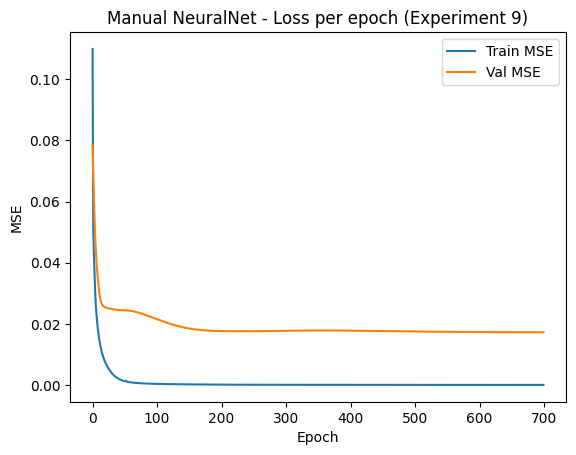

In [10]:

# Loss curves for the selected experiment

plt.figure()
plt.plot(best_train_err, label="Train MSE")
if any(e is not None for e in best_val_err):
    plt.plot([e for e in best_val_err if e is not None], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title(f"Manual NeuralNet - Loss per epoch (Experiment {chosen_experiment})")
plt.legend()
plt.show()


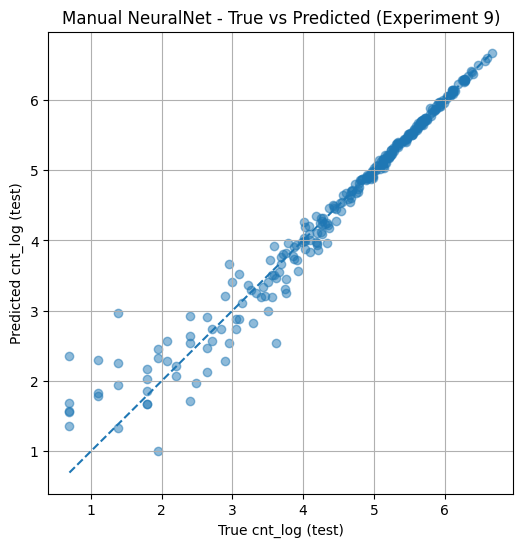

In [11]:

# Scatter plot: true vs predicted on TEST set

# Predictions in scaled space
y_test_pred_scaled = predict_batch(best_model, X_test_np)

# Back to original target scale
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled).ravel()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted cnt_log (test)")
plt.title(f"Manual NeuralNet - True vs Predicted (Experiment {chosen_experiment})")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")  # ideal y = x line
plt.grid(True)
plt.show()


## Summary of manual BP experiments

In this notebook we:

- Loaded the datasets from (`../data`).
- Defined several neural network configurations for the manual BP model
  (different number of hidden units, activation functions, learning rate, momentum, epochs).
- For each configuration we trained the model and computed:
  - MSE, MAE and MAPE on the 80% (train+validation),
  - MSE, MAE and MAPE on the 20% test set.
- Collected the results in a comparison table and selected one experimentaccording to its performance on the test set.

The selected configuration will be used later to compare:

- Manual BP vs Multiple Linear Regression (MLR),
- Manual BP vs PyTorch neural network

in the next notebook: **A1_3_MLR_and_PyTorch_Comparison.ipynb**.
